In [25]:
from hossam import *
from pandas import DataFrame, Series, concat
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from itertools import product
from scipy.spatial import ConvexHull


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# 성능 평가 지표 모듈
from sklearn.metrics import *


import sys

sys.path.append("/Users/jinwoo/Machine_Learning")

from hs_eval_utils import (
    hs_get_scores,
    hs_learning_cv,
    hs_get_score_cv,
    feature_importance,
    hs_shap_analysis,
    hs_describe,
    category_describe,
)

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    precision_recall_curve,
)

In [26]:
origin = load_data("pima_indians_diabetes_preprocessed")
origin.head()

캐글에서 제공하는 pima_indians_diabetes의 전처리 완료 버전(결측치 정제+로그변환) (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.946,5.004,72,3.584,4.836,3.544,0.487,3.932,1
1,0.693,4.454,66,3.401,4.836,3.318,0.301,3.466,0
2,2.197,5.215,64,3.401,4.836,3.190,0.514,3.497,1
3,0.693,4.500,66,3.178,4.554,3.371,0.154,3.091,0
4,0.000,4.927,40,3.584,5.130,3.786,1.190,3.526,1


In [27]:
df = origin.copy()

df["Outcome"] = df["Outcome"].astype("int")

yname = "Outcome"
x = df.drop(columns=[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [28]:
%%time

pipe = Pipeline(
    [
        ("VIF_Selector", VIFSelector()),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(random_state=52)),
    ]
)

param_grid = {
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"],
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__max_iter": [100, 300, 500],
    "model__class_weight": [None, "balanced"],
}

gs = GridSearchCV(
    estimator=pipe, param_grid=param_grid, cv=5, scoring="roc_auc", n_jobs=-1
)

gs.fit(x_train, y_train)

estimator = gs.best_estimator_
estimator

CPU times: user 130 ms, sys: 94.4 ms, total: 224 ms
Wall time: 4.47 s


Pipeline(steps=[('VIF_Selector', VIFSelector()), ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, class_weight='balanced',
                                    random_state=52))])

In [29]:
def hs_cls_bin_scores(estimator, x_test, y_test):
    # 위, 아래 활용
    y_pred_proba = estimator.predict_proba(x_test)

    # 1로 분류될 확률
    y_pred_proba_1 = estimator.predict_proba(x_test)[:, 1]

    # 예측값
    y_pred = estimator.predict(x_test)

    # 의사결정계수
    log_loss_test = -log_loss(y_test, y_pred_proba, normalize=False)
    y_null = np.ones_like(y_test) * y_test.mean()
    log_loss_null = -log_loss(y_test, y_null, normalize=False)
    pseudo_r2 = 1 - (log_loss_test / log_loss_null)

    # 혼동행렬
    cm = confusion_matrix(y_test, y_pred)
    ((TN, FP), (FN, TP)) = cm

    # 클래스 이름
    if hasattr(estimator, "named_steps"):
        classname = estimator.named_steps["model"].__class__.__name__
    else:
        classname = estimator.__class__.__name__

    # auc score
    auc = roc_auc_score(y_test, y_pred_proba_1)

    score_df = DataFrame(
        {
            "정확도(Accuracy)": [accuracy_score(y_test, y_pred)],
            "정밀도(Precision)": [precision_score(y_test, y_pred)],
            "재현율(Recall,tpr)": [recall_score(y_test, y_pred)],
            "위양성율(Fallout,fpr)": [FP / (TN + FP)],
            "특이성(TNR)": [1 - (FP / (TN + FP))],
            "F1 Score": [f1_score(y_test, y_pred)],
            "AUC": [auc],
        },
        index=[classname],
    )

    # ==========================
    # ROC 곡선 그리기
    # ==========================
    roc_fpr, roc_tpr, thresholds = roc_curve(y_test, y_pred_proba_1)

    # 1) 그래프 초기화
    my_dpi = 100  # 그래프 해상도

    width_px = 1000  # 그래프 가로 크기
    height_px = 900  # 그래프 세로 크기
    rows = 1  # 그래프 행 수
    cols = 1  # 그래프 열 수
    figsize = (width_px / my_dpi, height_px / my_dpi)
    fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

    # 2) LinePlot 그리기
    sb.lineplot(x=roc_fpr, y=roc_tpr)
    sb.lineplot(x=[0, 1], y=[0, 1], color="red", linestyle=":", alpha=0.5)
    plt.fill_between(x=roc_fpr, y1=roc_tpr, alpha=0.1)

    # 3) 그래프 꾸미기
    ax.grid(True, alpha=0.3)  # 배경 격자 표시
    ax.set_title(f"AUC={auc:.4f}", fontsize=10, pad=4)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # 4) 출력
    plt.tight_layout()  # 여백 제거
    plt.show()  # 그래프 화면 출력
    plt.close()  # 그래프 작업 종료

    return score_df

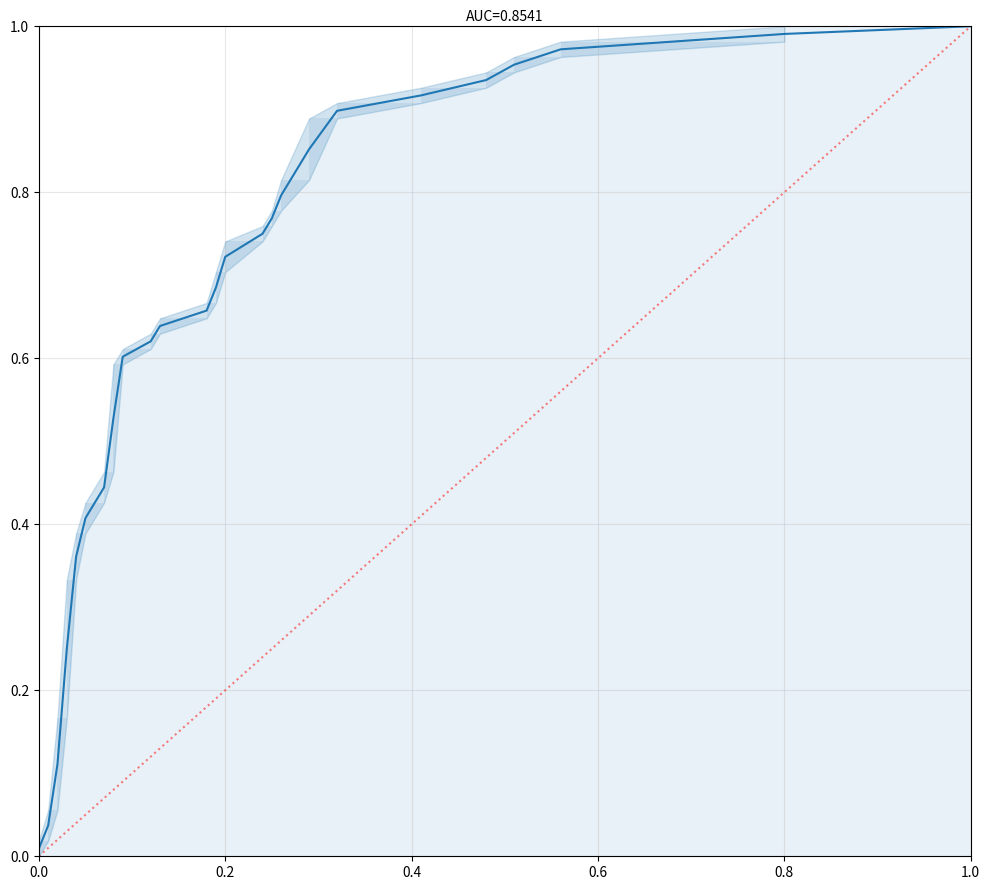

,정확도(Accuracy),정밀도(Precision),"재현율(Recall,tpr)","위양성율(Fallout,fpr)",특이성(TNR),F1 Score,AUC
LogisticRegression,0.766,0.629,0.815,0.260,0.740,0.710,0.854


In [30]:
hs_cls_bin_scores(estimator, x_test, y_test)

In [31]:
def hs_learning_cv(
    estimator,
    x,
    y,
    scoring=None,  # <-- None 으로 기본값 수정
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
):
    # -------------------------------------------------
    # [NEW] 문제 유형 자동 판별
    # -------------------------------------------------
    is_classification = (
        hasattr(estimator, "_estimator_type")
        and estimator._estimator_type == "classifier"
    )

    # -------------------------------------------------
    # [NEW] scoring 자동 설정
    # -------------------------------------------------
    if scoring is None:
        scoring = "roc_auc" if is_classification else "neg_root_mean_squared_error"

    # -------------------------------------------------
    # learning curve 계산 (기존과 동일)
    # -------------------------------------------------
    train_sizes, train_scores, cv_scores = learning_curve(  # type: ignore
        estimator=estimator,
        X=x,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=False,
        random_state=52,
    )

    # -------------------------------------------------
    # 모델명 추출 (Pipeline 대응, 변경 여부 체크 필요)
    # -------------------------------------------------
    if hasattr(estimator, "named_steps"):
        classname = estimator.named_steps["model"].__class__.__name__
    else:
        classname = estimator.__class__.__name__

    # =================================================
    # 회귀 전용 처리 (기존 코드, if문은 추가)
    # =================================================
    if not is_classification:
        # neg RMSE → RMSE
        train_rmse = -train_scores
        cv_rmse = -cv_scores

        # 평균 / 표준편차
        train_mean = train_rmse.mean(axis=1)
        cv_mean = cv_rmse.mean(axis=1)
        cv_std = cv_rmse.std(axis=1)

        # 마지막 지점 기준 정량 판정
        final_train = train_mean[-1]
        final_cv = cv_mean[-1]
        final_std = cv_std[-1]

        gap_ratio = final_train / final_cv
        var_ratio = final_std / final_cv

        # -----------------
        # 과소적합 기준선 (some_threshold)
        # -----------------
        # 기준모형 RMSE (평균 예측)
        y_mean = y.mean()
        rmse_naive = np.sqrt(np.mean((y - y_mean) ** 2))

        # 분산 기반
        std_y = y.std()

        # 최소 설명력(R²) 기반
        min_r2 = 0.10
        rmse_r2 = np.sqrt((1 - min_r2) * np.var(y))

        # 최종 threshold (가장 관대한 기준)
        # -> 원래 some_threshold는 도메인 지식 수준에서 이 모델은 최소 어느 정도의 성능은 내야 한다는 기준을 설
        # 정하는 것
        some_threshold = min(rmse_naive, std_y, rmse_r2)

        # -----------------
        # 판정 로직
        # -----------------
        # 마지막 두 지점 기울기
        train_slope = train_mean[-1] - train_mean[-2]
        cv_slope = cv_mean[-1] - cv_mean[-2]

        if gap_ratio >= 0.95 and final_cv > some_threshold:
            status = " 과소적합"
        elif gap_ratio <= 0.8 and train_slope > 0 and cv_slope < 0:
            status = " 데이터 추가시 일반화 기대"
        elif gap_ratio <= 0.8:
            status = " 과대적합"
        elif gap_ratio <= 0.95 and var_ratio <= 0.10:
            status = " 일반화 양호"
        elif var_ratio > 0.15:
            status = " 데이터 부족"
        else:
            status = " 판단유보"

        # [NEW] 평가 지표 이름
        metric_name = "RMSE"

    # =================================================
    # 분류 전용 처리 (신규 코드)
    # =================================================
    else:
        # [NEW] 분류는 그대로 사용 (AUC, Accuracy 등)
        train_metric = train_scores
        cv_metric = cv_scores

        train_mean = train_metric.mean(axis=1)
        cv_mean = cv_metric.mean(axis=1)
        cv_std = cv_metric.std(axis=1)

        final_train = train_mean[-1]
        final_cv = cv_mean[-1]
        final_std = cv_std[-1]

        # [NEW] 분류용 비율 정의 (차이 기반)
        gap_ratio = final_train - final_cv
        var_ratio = final_std

        # -----------------
        # [NEW] 분류 판정 로직 (객관적 기준)
        # -----------------
        if final_train < 0.6 and final_cv < 0.6:
            status = " 과소적합"
        elif gap_ratio > 0.1:
            status = " 과대적합"
        elif gap_ratio <= 0.05 and var_ratio <= 0.05:
            status = " 일반화 양호"
        elif var_ratio > 0.1:
            status = " 데이터 부족"
        else:
            status = " 판단유보"

        metric_name = scoring.upper()

    # -----------------
    # 정량 결과 표 (수정)
    # -----------------
    result_df = DataFrame(
        {
            f"Train {metric_name}": [final_train],
            f"CV {metric_name} 평균": [final_cv],
            f"CV {metric_name} 표준편차": [final_std],
            f"Train/CV 비율": [gap_ratio],
            f"CV 변동성 비율": [var_ratio],
            "판정 결과": [status],
        },
        index=[classname],
    )

    # -----------------
    # 학습곡선 시각화 (기존과 동일)
    # -----------------
    figsize = (1280 / my_dpi, 720 / my_dpi)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

    sb.lineplot(
        x=train_sizes,
        y=train_mean,
        marker="o",
        markeredgecolor="#ffffff",
        label="Train RMSE",
    )

    sb.lineplot(
        x=train_sizes,
        y=cv_mean,
        marker="o",
        markeredgecolor="#ffffff",
        label="Train RMSE",
    )

    # 함수 확인
    ax.set_xlabel("RMSE", fontsize=8, labelpad=5)
    ax.set_ylabel("학습곡선 (Learning Curve)", fontsize=8, labelpad=5)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close()

    return result_df

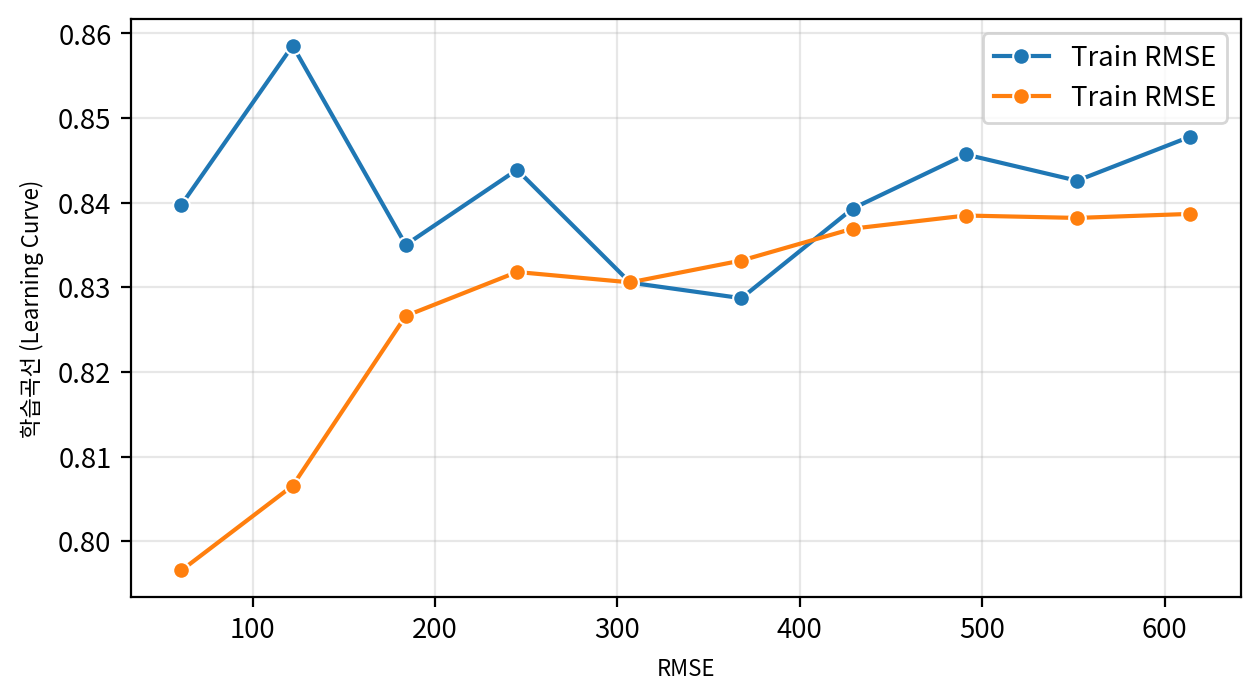

,Train ROC_AUC,CV ROC_AUC 평균,CV ROC_AUC 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
LogisticRegression,0.848,0.839,0.030,0.009,0.030,일반화 양호


In [32]:
hs_learning_cv(estimator, x, y)